In [1]:
import os
from dataclasses import dataclass
from pathlib import Path

In [2]:
os.environ["MLFLOW_TRACKING_URI"]= "https://dagshub.com/amilasnils008/Data-science-end-to-end-project.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]= "amilasnils008"
os.environ["MLFLOW_TRACKING_PASSWORD"]= "f34b09f6dafe0c38be253c9456fe1018d05a4b88"

In [3]:
%pwd

'c:\\Users\\amil\\OneDrive\\Documents\\Data_Science_end_to_end_project\\research'

In [4]:
os.chdir('../')
%pwd

'c:\\Users\\amil\\OneDrive\\Documents\\Data_Science_end_to_end_project'

In [5]:
@dataclass
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict
    metric_file_name: Path
    target_column: str
    mlflow_uri: str

In [6]:
from src.constants import *
from src.utils.common import read_yaml,save_json,create_directories

In [7]:
class ConfigurationManager:
    def __init__(self,
                config_file_path = CONFIG_FILE_PATH,
                params_file_path = PARAMS_FILE_PATH,
                schema_file_path = SCHEMA_FILE_PATH):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)
        self.schema = read_yaml(schema_file_path)
        
        create_directories([self.config.artifacts_root])
        
    
    def get_model_evaluation_config(self)-> ModelEvaluationConfig :
        config = self.config.model_evaluation 
        params = self.params.ElasticNet
        schema = self.schema.TARGET_COLUMN

        create_directories([config.root_dir])
        
        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data_path=config.test_data_path,
            model_path=config.model_path,
            all_params=params,
            metric_file_name=config.metric_file_name,
            target_column=schema.name,
            mlflow_uri= "https://dagshub.com/amilasnils008/Data-science-end-to-end-project.mlflow"
        )
        
        return model_evaluation_config
    

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import joblib


c:\Users\amil\OneDrive\Documents\Data_Science_end_to_end_project\venv\lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [9]:
class ModelEvaluation:
    def __init__(self, config = ModelEvaluationConfig):
        self.config = config
    
    def eval_metrics(self,actual, pred):
        rmse = np.sqrt(mean_squared_error(actual,pred))
        mae = mean_absolute_error(actual,pred)
        r2 = r2_score(actual,pred)
        return rmse,mae,r2
    
    def log_to_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        model = joblib.load(self.config.model_path)

        test_X = test_data.drop([self.config.target_column], axis=1)
        test_Y = test_data[[self.config.target_column]]

        mlflow.set_tracking_uri(self.config.mlflow_uri)

        mlflow.set_experiment("ElasticNet_Regression_Experiment")

        with mlflow.start_run(run_name="Model_Evaluation_Run"):
            predicted_qualities = model.predict(test_X)
            rmse, mae, r2 = self.eval_metrics(test_Y, predicted_qualities)
            
            scores = {"rmse": rmse, "mae": mae, "r2": r2}
            save_json(path=Path(self.config.metric_file_name), data=scores)
    
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(scores)
    
            # Model Signature
            from mlflow.models import infer_signature
            signature = infer_signature(test_X, model.predict(test_X))
    
            # Tags
            mlflow.set_tags({
                "model_type": "ElasticNet Regression",
                "developer": "Muhammed Amil",
                "dataset": "Wine Quality",
                "stage": "evaluation"
            })
    
            # Plot as Artifact
            import matplotlib.pyplot as plt
            plt.scatter(test_Y, predicted_qualities)
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title("Actual vs Predicted")
            plot_path = "reports/actual_vs_predicted.png"
            os.makedirs("reports", exist_ok=True)
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)
    
            # Model Logging
            mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="model",
                signature=signature,
                input_example=test_X.iloc[:1]
            )


[2025-11-02 18:46:16,899:, INFO:, common:, yaml file : config\config.yaml loaded successfully]
[2025-11-02 18:46:16,904:, INFO:, common:, yaml file : params.yaml loaded successfully]
[2025-11-02 18:46:16,907:, INFO:, common:, yaml file : schema.yaml loaded successfully]
[2025-11-02 18:46:16,908:, INFO:, common:, created directory for artifacts]
[2025-11-02 18:46:16,911:, INFO:, common:, created directory for artifacts/model_evaluation]
[2025-11-02 18:46:19,507:, INFO:, common:, JSON file saved at path: artifacts\model_evaluation\metrics.json]


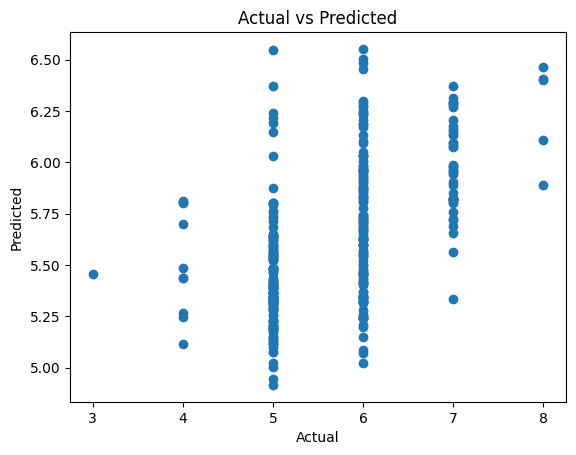

In [10]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config= model_evaluation_config)
    model_evaluation.log_to_mlflow()
except Exception as e:
    raise e

In [11]:
import mlflow
print(mlflow.__version__)


2.7.1
